In [152]:
import datetime
from collections import defaultdict
import warnings

from lightning.pytorch.callbacks import ModelCheckpoint
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from stock_indicators.indicators.common.enums import PeriodSize
from lightning.pytorch.callbacks.model_summary import ModelSummary

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

In [17]:
funds_w_names = defaultdict(pd.DataFrame)

In [18]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B5M4WH52','IE00B66F4759','EMBE.L', 'DTLE.L','IE00BDFK1573','IBC5.DE','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF', "IESE.AS", "UEEF.DE"]

In [ ]:
print(etf_names)

In [52]:
for fund in etf_names:
    print(fund)
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-03", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)

    a["Return"] = a["Close"].pct_change()
    a["Rolling Volatility"] = a["Return"].rolling(7).std()

    a.fillna(method="bfill", inplace=True)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    a.index = pd.to_datetime(a.index, utc=True)
    if a.index.hour[0]==0:
        a.index = a.index+datetime.timedelta(hours=-1)
    a.index = a.index.normalize()

    a = a.sort_index()

    a["time_idx"] = (a.index - a.index.min()).days
    a["group_id"] = fund
    funds_w_names[fund] = a

IE0005042456
EDMU.SW
EDG2.L
36BA.DE
CBUS.DE
EWSA.AS
IE00B0M62X26
IE00B14X4Q57
IE00B1XNHC34
IE00B3FH7618
IE00B3ZW0K18
IE00B52MJY50
IE00B5M4WH52
IE00B66F4759
EMBE.L
DTLE.L
IE00BDFK1573
IBC5.DE
IE00BFNM3G45
IE00BHZPJ015
IE00BHZPJ452
IE00BHZPJ783
IE00BLDGH553
IE00BMG6Z448
IE00BYYHSM20
IE00BYZTVT56
IE00BZ173V67
IE00BZ1NCS44
ISVIF
IESE.AS
UEEF.DE


In [ ]:
# import pickle
# pickle.dump(funds_w_names, open('funds_w_names.pkl', 'wb'))

In [ ]:
# import pickle
# pickle.dump(funds_w_names, open('funds_w_names_2.pkl', 'wb'))

In [4]:
funds_w_names = pd.read_pickle('funds_w_names_2.pkl')

In [14]:
funds_w_names["EWSA.AS"]

,Open,High,Low,Close,Volume,Return,Rolling Volatility
2023-01-02 00:00:00+01:00,4.212700,4.212700,4.212700,4.212700,0.000000,-0.001329,0.010618
2023-01-03 00:00:00+01:00,4.201800,4.215000,4.201800,4.207100,66.000000,-0.001329,0.010618
2023-01-04 00:00:00+01:00,4.195300,4.224300,4.195300,4.224300,1900.000000,0.004088,0.010618
2023-01-05 00:00:00+01:00,4.221000,4.221000,4.221000,4.221000,0.000000,-0.000781,0.010618
2023-01-06 00:00:00+01:00,4.190500,4.190500,4.190500,4.190500,0.000000,-0.007226,0.010618
...,...,...,...,...,...,...,...
2023-12-25 00:00:00+01:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.007116
2023-12-26 00:00:00+01:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.005419
2023-12-27 00:00:00+01:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.009261,0.005989
2023-12-28 00:00:00+01:00,4.844000,4.844000,4.807200,4.807200,5484.000000,-0.002014,0.004963


In [44]:
def portfolio_factory(etfs: list):
    #giga_fund = pd.DataFrame()
    for c, ff in enumerate(etfs):
        #f = ff.copy()

        ff.index = pd.to_datetime(ff.index, utc=True)
        if ff.index.hour[0]==0:
            ff.index = ff.index+datetime.timedelta(hours=-1)
        ff.index = ff.index.normalize()

        ff = ff.sort_index()

        ff["time_idx"] = (ff.index - ff.index.min()).days
        ff["group_id"] = c
        #f = f.reset_index()

        #giga_fund = pd.concat([giga_fund, f], ignore_index=True)
    #return giga_fund

In [48]:
funds_w_names["EWSA.AS"]

,Open,High,Low,Close,Volume,Return,Rolling Volatility
2023-01-02 00:00:00+00:00,4.201800,4.215000,4.201800,4.207100,66.000000,0.004088,0.010457
2023-01-03 00:00:00+00:00,4.195300,4.224300,4.195300,4.224300,1900.000000,0.004088,0.010457
2023-01-04 00:00:00+00:00,4.221000,4.221000,4.221000,4.221000,0.000000,-0.000781,0.010457
2023-01-05 00:00:00+00:00,4.190500,4.190500,4.190500,4.190500,0.000000,-0.007226,0.010457
2023-01-06 00:00:00+00:00,4.298600,4.298600,4.298600,4.298600,0.000000,0.000000,0.010457
...,...,...,...,...,...,...,...
2023-12-24 00:00:00+00:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.007116
2023-12-25 00:00:00+00:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.005419
2023-12-26 00:00:00+00:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.009261,0.005989
2023-12-27 00:00:00+00:00,4.844000,4.844000,4.807200,4.807200,5484.000000,-0.002014,0.004963


In [ ]:
pd.options.display.date_yearfirst = True
pd.options.display.float_format = '{:.2f}'.format

In [22]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):
        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in f.itertuples()]


        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)


        rsi_for_f = sa.indicators.get_rsi(quotes=quotes_for_f)
        valid_rsi_for_f = [
            (result.date, result.rsi)
            for result in rsi_for_f
            if result.date is not None and result.rsi is not None
        ]
        rsi_dates, rsi_values = zip(*valid_rsi_for_f)


        bb_for_f = sa.indicators.get_bollinger_bands(quotes=quotes_for_f)
        valid_bb_for_f = [
            (result.date, result.lower_band, result.upper_band)
            for result in bb_for_f
            if result.date is not None and result.lower_band is not None
        ]
        bb_dates, bb_lower, bb_upper = zip(*valid_bb_for_f)


        vwap_for_f = sa.indicators.get_vwap(quotes=quotes_for_f)
        valid_vwap_for_f = [
            (result.date, result.vwap)
            for result in vwap_for_f
            if result.date is not None and result.vwap is not None
        ]
        vwap_dates, vwap_values = zip(*valid_vwap_for_f)



        pp_for_f = sa.indicators.get_pivot_points(quotes=quotes_for_f, window_size=PeriodSize.DAY)
        valid_pp_for_f = [
            (result.date, result.pp, result.r1, result.r2, result.r3, result.r4, result.s1, result.s2, result.s3, result.s4)
            for result in pp_for_f
            if result.date is not None and result.pp is not None
        ]
        pp_dates, pp, r1, r2, r3, r4, s1, s2, s3, s4 = zip(*valid_pp_for_f)




        fig, axes = plt.subplots(5, 1, figsize=(12,6))


        axes[0].plot(macd_dates[-20:], macd_values[-20:], label='MACD_values', linewidth=2)
        axes[0].plot(macd_dates[-20:], macd_signal[-20:], label='MACD_signal', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(rsi_dates[-20:], rsi_values[-20:], label='RSI', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(bb_dates[-20:], bb_lower[-20:], label='BB_lower', linewidth=2)
        axes[2].plot(bb_dates[-20:], bb_upper[-20:], label='BB_upper', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(vwap_dates[-20:], vwap_values[-20:], label='vwap', linewidth=2)
        axes[3].legend(loc='best')

        axes[4].plot(pp_dates[-20:], pp[-20:], label='pivot points', linewidth=2)
        axes[4].plot(pp_dates[-20:], r1[-20:], label='r1', linewidth=2)
        axes[4].plot(pp_dates[-20:], r4[-20:], label='r4', linewidth=2)
        axes[4].plot(pp_dates[-20:], s1[-20:], label='s1', linewidth=2)
        axes[4].plot(pp_dates[-20:], s4[-20:], label='s4', linewidth=2)
        axes[4].legend(loc='best')


        figs.append(fig)

        f['Bullish'] = [1 if x.histogram and x.histogram > 0 else 0 for x in macd_for_f]
        f['Bearish'] = [1 if x.histogram and x.histogram < 0 else 0 for x in macd_for_f]
        f['isOverbought'] = [1 if x.rsi and x.rsi > 70 else 0 for x in rsi_for_f ]
        f['isOversold'] = [1 if x.rsi and x.rsi < 30 else 0 for x in rsi_for_f ]


        f.fillna(method="ffill", inplace=True)
        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [126]:
funds_w_names["EWSA.AS"]

,Open,High,Low,Close,Volume,Return,Rolling Volatility,time_idx,group_id
2023-01-02 00:00:00+00:00,4.201800,4.215000,4.201800,4.207100,66.000000,0.004088,0.010457,0,EWSA.AS
2023-01-03 00:00:00+00:00,4.195300,4.224300,4.195300,4.224300,1900.000000,0.004088,0.010457,1,EWSA.AS
2023-01-04 00:00:00+00:00,4.221000,4.221000,4.221000,4.221000,0.000000,-0.000781,0.010457,2,EWSA.AS
2023-01-05 00:00:00+00:00,4.190500,4.190500,4.190500,4.190500,0.000000,-0.007226,0.010457,3,EWSA.AS
2023-01-06 00:00:00+00:00,4.298600,4.298600,4.298600,4.298600,0.000000,0.000000,0.010457,4,EWSA.AS
...,...,...,...,...,...,...,...,...,...
2023-12-24 00:00:00+00:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.007116,356,EWSA.AS
2023-12-25 00:00:00+00:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.005419,357,EWSA.AS
2023-12-26 00:00:00+00:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.009261,0.005989,358,EWSA.AS
2023-12-27 00:00:00+00:00,4.844000,4.844000,4.807200,4.807200,5484.000000,-0.002014,0.004963,359,EWSA.AS


In [127]:
def fit(epochs: int, batch_size: int, lr: float, dropout: float, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx: pd.Timestamp=330):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],     # Use the determined cutoff index
        time_idx="time_idx",                                 # Sequential time index
        target=target,                                       # Target variable
        group_ids=["group_id"],                              # Group identifier
        min_encoder_length=22,                               # Minimum input sequence length
        max_encoder_length=120,                              # Maximum input sequence length
        min_prediction_length=1,                             # Minimum forecast length
        max_prediction_length=31,                            # Maximum forecast length (31 for December)
        static_categoricals=["group_id"],
        static_reals=[],                                     # No static real variables
        time_varying_known_reals= independent_variables,     # Known inputs
        time_varying_unknown_reals=[target],                 # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,                          # Add relative time index
        add_target_scales=True,                              # Scale the target variable
        add_encoder_length=True,                             # Include encoder length feature
        allow_missing_timesteps=False,                       # Ensure no missing steps
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True                             # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=lr,                # Learning rate
        hidden_size=16,                  # Model hidden size
        attention_head_size=4,           # Number of attention heads
        dropout=dropout,                 # Dropout rate
        hidden_continuous_size=8,        # Hidden size for continuous variables
        output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),             # Loss function
        log_interval=10,                 # Log every 10 batches
        reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cpu',
        devices="auto",
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_logger],#, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    return tft, training, val_dataloader

In [89]:
def predictt(tft, training, data):
    # pred_data = TimeSeriesDataSet.from_dataset(
    #     dataset=training,
    #     data=data,
    #     predict=True,
    #     stop_randomization=True)
    # 
    # pred_dataloader = pred_data.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

    raw_predictions = tft.predict(data, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [25]:
def huber_loss(actual_val, pred_val, delta=5.0):
    err = np.abs(actual_val - pred_val)
    return np.mean(np.where( err <= delta, 0.5 * err**2, delta * (err - 0.5 * delta)))

In [26]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range, target="Close", date = "2023-12-01"):
    print(len(df))
    print(len(preds))
    actual_values = df[target][date:]
    mse = mean_squared_error(actual_values, preds)
    mape = mean_absolute_percentage_error(actual_values, preds)
    huber = huber_loss(actual_values, preds)
    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for December 01 to December 29, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return mse, plt, mape, huber

BASELINE MODEL

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import GARCH

In [28]:
f1 = funds_w_names['EWSA.AS']["Close"][:-30]

In [29]:
model = ARIMA(f1, order=(1, 1, 1))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=30)
print("ARIMA Forecast for the next 30 periods:", arima_forecast)

ARIMA Forecast for the next 30 periods: 2023-11-30 00:00:00+01:00   4.364407
2023-12-01 00:00:00+01:00   4.364255
2023-12-02 00:00:00+01:00   4.364312
2023-12-03 00:00:00+01:00   4.364290
2023-12-04 00:00:00+01:00   4.364298
2023-12-05 00:00:00+01:00   4.364295
2023-12-06 00:00:00+01:00   4.364296
2023-12-07 00:00:00+01:00   4.364296
2023-12-08 00:00:00+01:00   4.364296
2023-12-09 00:00:00+01:00   4.364296
2023-12-10 00:00:00+01:00   4.364296
2023-12-11 00:00:00+01:00   4.364296
2023-12-12 00:00:00+01:00   4.364296
2023-12-13 00:00:00+01:00   4.364296
2023-12-14 00:00:00+01:00   4.364296
2023-12-15 00:00:00+01:00   4.364296
2023-12-16 00:00:00+01:00   4.364296
2023-12-17 00:00:00+01:00   4.364296
2023-12-18 00:00:00+01:00   4.364296
2023-12-19 00:00:00+01:00   4.364296
2023-12-20 00:00:00+01:00   4.364296
2023-12-21 00:00:00+01:00   4.364296
2023-12-22 00:00:00+01:00   4.364296
2023-12-23 00:00:00+01:00   4.364296
2023-12-24 00:00:00+01:00   4.364296
2023-12-25 00:00:00+01:00   4.36429

In [30]:
arima_mse = mean_squared_error(funds_w_names["EWSA.AS"]["Close"][-30:], arima_forecast)

In [31]:
sf = StatsForecast(models=[GARCH()], freq='D')
f1=pd.DataFrame(f1)
f1['ds'] = pd.to_datetime(f1.index)
f1.rename(columns={'Close': 'y'}, inplace=True)
f1['unique_id']=1

In [32]:
garch_forecast = sf.forecast(h=30, df=f1)

print(garch_forecast)

    unique_id                        ds  GARCH(1,1)
0           1 2023-11-30 00:00:00+01:00    0.269404
1           1 2023-12-01 00:00:00+01:00   -0.101462
2           1 2023-12-02 00:00:00+01:00   -0.087599
3           1 2023-12-03 00:00:00+01:00   -0.177956
4           1 2023-12-04 00:00:00+01:00    0.143531
5           1 2023-12-05 00:00:00+01:00   -0.381719
6           1 2023-12-06 00:00:00+01:00    0.289384
7           1 2023-12-07 00:00:00+01:00   -0.126249
8           1 2023-12-08 00:00:00+01:00    0.052914
9           1 2023-12-09 00:00:00+01:00   -0.041359
10          1 2023-12-10 00:00:00+01:00    0.242496
11          1 2023-12-11 00:00:00+01:00   -0.341683
12          1 2023-12-12 00:00:00+01:00   -0.053474
13          1 2023-12-13 00:00:00+01:00   -0.063697
14          1 2023-12-14 00:00:00+01:00    0.188040
15          1 2023-12-15 00:00:00+01:00   -0.182421
16          1 2023-12-16 00:00:00+01:00   -0.028598
17          1 2023-12-17 00:00:00+01:00   -0.145596
18          

In [33]:
garch_mse = mean_squared_error(funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], garch_forecast["GARCH(1,1)"])

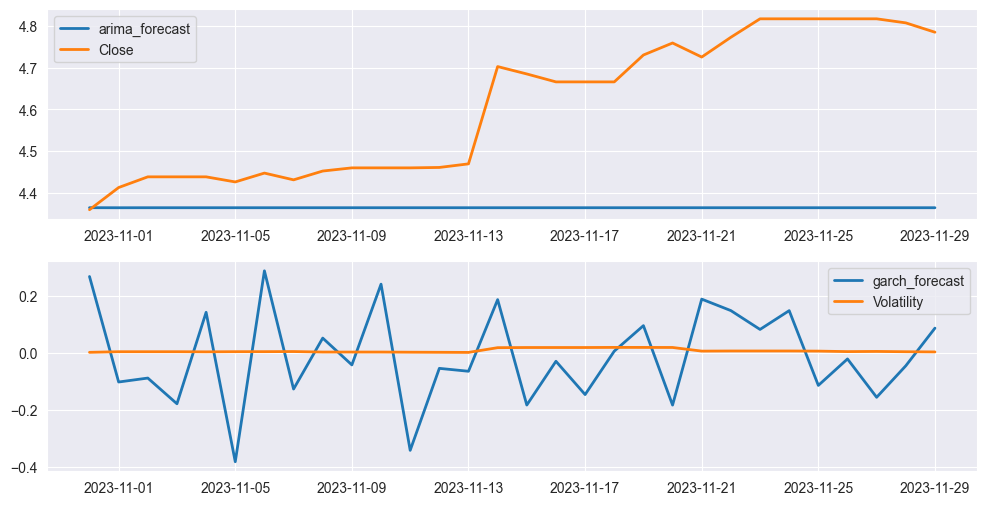

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))


axes[0].plot(f1['ds'][-30:], arima_forecast[-30:], label='arima_forecast', linewidth=2)
axes[0].plot(f1['ds'][-30:], funds_w_names["EWSA.AS"]["Close"][-30:], label='Close', linewidth=2)
axes[0].legend(loc='best')
axes[1].plot(f1['ds'][-30:], garch_forecast["GARCH(1,1)"], label='garch_forecast', linewidth=2)
axes[1].plot(f1['ds'][-30:], funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], label='Volatility', linewidth=2)
axes[1].legend(loc='best')
plt.legend()
plt.show()

NO INDICATORS, ONE ETF

In [50]:
#IE00B52MJY50
#IE = portfolio_factory(etfs=[funds_w_names['EWSA.AS']])

In [112]:
funds_w_names['EWSA.AS'][:"2023-10-29"]

,Open,High,Low,Close,Volume,Return,Rolling Volatility,time_idx,group_id
2023-01-02 00:00:00+00:00,4.201800,4.215000,4.201800,4.207100,66.000000,0.004088,0.010457,0,EWSA.AS
2023-01-03 00:00:00+00:00,4.195300,4.224300,4.195300,4.224300,1900.000000,0.004088,0.010457,1,EWSA.AS
2023-01-04 00:00:00+00:00,4.221000,4.221000,4.221000,4.221000,0.000000,-0.000781,0.010457,2,EWSA.AS
2023-01-05 00:00:00+00:00,4.190500,4.190500,4.190500,4.190500,0.000000,-0.007226,0.010457,3,EWSA.AS
2023-01-06 00:00:00+00:00,4.298600,4.298600,4.298600,4.298600,0.000000,0.000000,0.010457,4,EWSA.AS
...,...,...,...,...,...,...,...,...,...
2023-10-25 00:00:00+00:00,3.918600,3.918600,3.918600,3.944700,0.000000,-0.005321,0.006392,296,EWSA.AS
2023-10-26 00:00:00+00:00,3.957300,3.957300,3.957300,3.945300,0.000000,0.000152,0.003484,297,EWSA.AS
2023-10-27 00:00:00+00:00,3.939900,3.939900,3.939900,3.936400,0.000000,0.000000,0.003484,298,EWSA.AS
2023-10-28 00:00:00+00:00,3.939900,3.939900,3.939900,3.936400,0.000000,0.000000,0.003484,299,EWSA.AS


In [131]:
IE_tft, IE_training, val = fit(epochs=100, batch_size=128, lr=1e-3, dropout=0.1, df=funds_w_names['EWSA.AS'], independent_variables=["Open", "High", "Low", "Volume"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [132]:
IE_preds = predictt(IE_tft, IE_training, val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


361
31


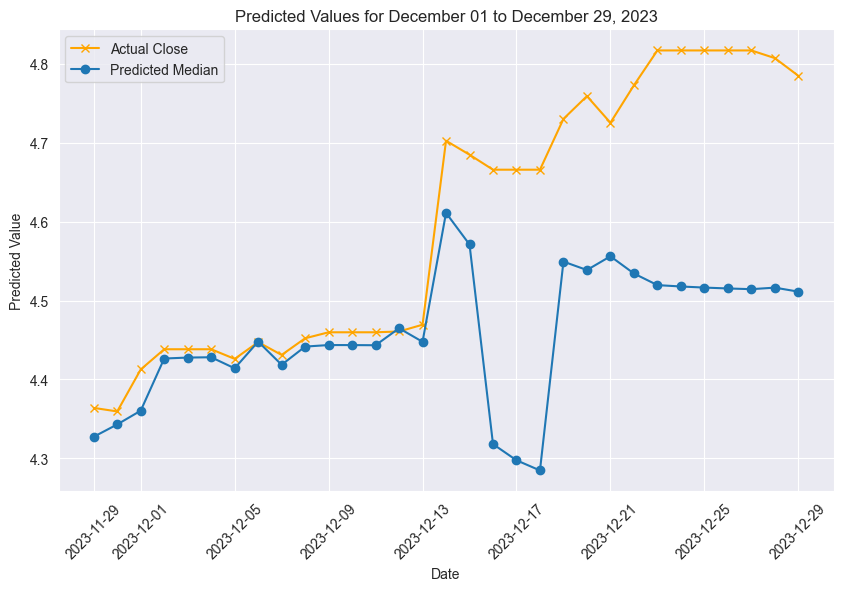

In [133]:
IE_mse, IE_plt, mape, huber = metrics_and_plt(funds_w_names['EWSA.AS'], IE_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [134]:
IE_mse

0.03890250992139221

ADDING INDICATORS

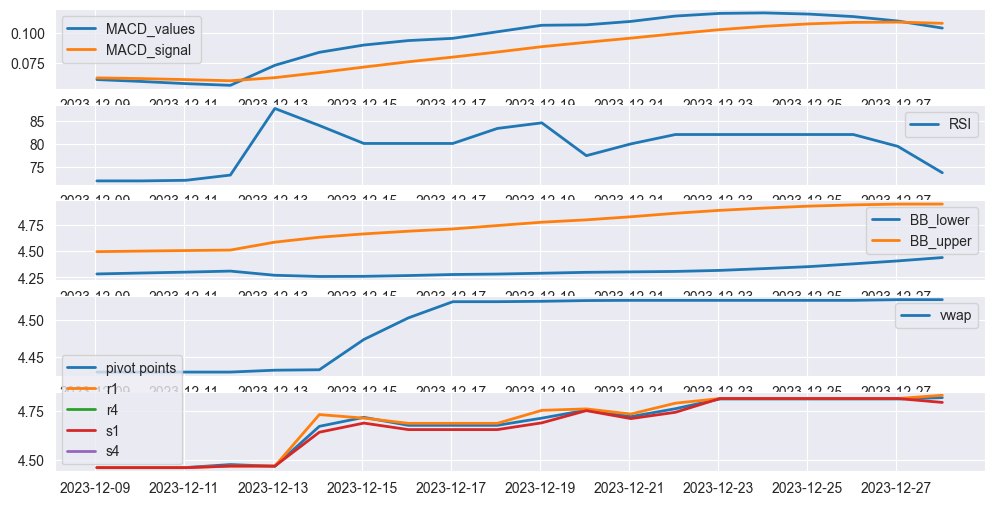

In [135]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['EWSA.AS']], ['EWSA.AS'])

In [136]:
analiza = IE_indicators["EWSA.AS"][["isOversold", "isOverbought", "Bullish", "Bearish", "Return"]]

<Axes: >

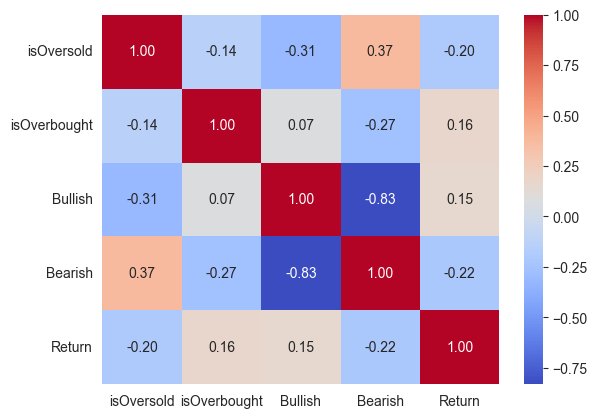

In [137]:
import seaborn as sns
corr1 = analiza.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", fmt=".2f")

In [139]:
correlations = IE_indicators["EWSA.AS"].corr()

ValueError: could not convert string to float: 'EWSA.AS'

In [138]:
import seaborn as sns

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")

NameError: name 'correlations' is not defined

In [141]:
IE_indicators_tft, IE_indicators_training, val = fit(epochs=100, batch_size=128, lr=1e-3, dropout=0.1, df=IE_indicators["EWSA.AS"], independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [142]:

IE_indicators_preds = predictt(IE_indicators_tft, IE_indicators_training, val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


361
31


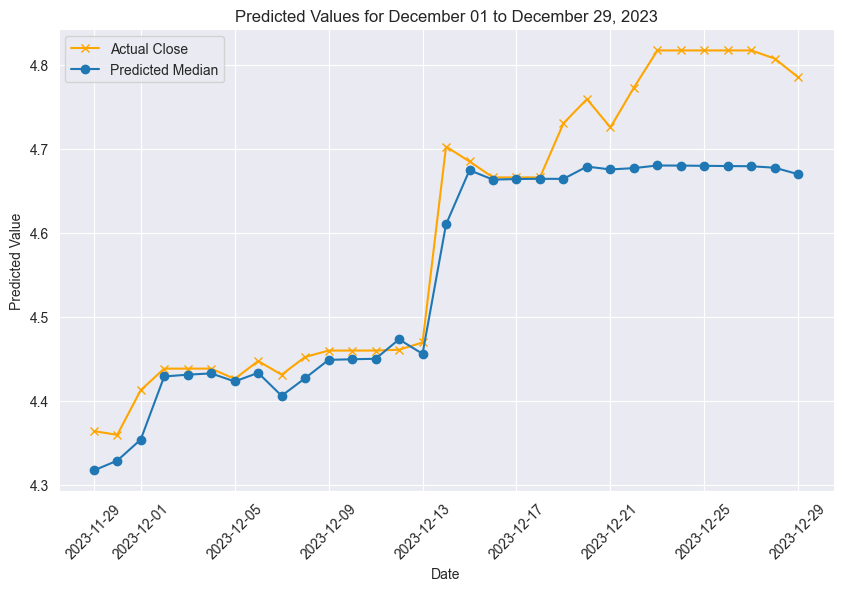

In [148]:
IE_indicators_mse, IE_indicators_plt2, mape, hub= metrics_and_plt(funds_w_names["EWSA.AS"], IE_indicators_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [149]:
IE_indicators_mse

0.0053059302763578614

ENSAMBLE MODEL 2: REMAINDERS

In [156]:
resztki = abs(IE_indicators_preds  - IE_indicators["EWSA.AS"]["Close"]["2023-11-28":])

In [157]:
resztki

2023-11-28 00:00:00+00:00   0.046837
2023-11-29 00:00:00+00:00   0.030697
2023-11-30 00:00:00+00:00   0.058787
2023-12-01 00:00:00+00:00   0.009333
2023-12-02 00:00:00+00:00   0.007194
2023-12-03 00:00:00+00:00   0.005672
2023-12-04 00:00:00+00:00   0.003078
2023-12-05 00:00:00+00:00   0.014006
2023-12-06 00:00:00+00:00   0.025120
2023-12-07 00:00:00+00:00   0.025254
2023-12-08 00:00:00+00:00   0.011061
2023-12-09 00:00:00+00:00   0.010346
2023-12-10 00:00:00+00:00   0.009778
2023-12-11 00:00:00+00:00   0.012331
2023-12-12 00:00:00+00:00   0.013505
2023-12-13 00:00:00+00:00   0.092555
2023-12-14 00:00:00+00:00   0.010357
2023-12-15 00:00:00+00:00   0.002641
2023-12-16 00:00:00+00:00   0.001904
2023-12-17 00:00:00+00:00   0.001630
2023-12-18 00:00:00+00:00   0.066118
2023-12-19 00:00:00+00:00   0.080282
2023-12-20 00:00:00+00:00   0.050002
2023-12-21 00:00:00+00:00   0.095809
2023-12-22 00:00:00+00:00   0.136885
2023-12-23 00:00:00+00:00   0.137015
2023-12-24 00:00:00+00:00   0.137286
2

In [159]:
df_scary = IE_indicators["EWSA.AS"][333:].copy()
df_scary["Remainders"] = resztki

In [160]:
df_scary

,Open,High,Low,Close,Volume,Return,Rolling Volatility,time_idx,group_id,Bullish,Bearish,isOverbought,isOversold,Remainders
2023-12-01 00:00:00+00:00,4.438200,4.456400,4.438200,4.438300,475.000000,0.000000,0.005019,333,EWSA.AS,1,0,1,0,0.009333
2023-12-02 00:00:00+00:00,4.438200,4.456400,4.438200,4.438300,475.000000,0.000000,0.005019,334,EWSA.AS,1,0,1,0,0.007194
2023-12-03 00:00:00+00:00,4.438200,4.456400,4.438200,4.438300,475.000000,0.005801,0.004585,335,EWSA.AS,1,0,1,0,0.005672
2023-12-04 00:00:00+00:00,4.438700,4.443600,4.420000,4.426100,1192.000000,-0.002749,0.005149,336,EWSA.AS,1,0,1,0,0.003078
2023-12-05 00:00:00+00:00,4.438100,4.474700,4.436800,4.447300,80921.000000,0.004790,0.005204,337,EWSA.AS,1,0,1,0,0.014006
2023-12-06 00:00:00+00:00,4.425100,4.442300,4.411300,4.431100,60341.000000,-0.003643,0.005596,338,EWSA.AS,1,0,0,0,0.025120
2023-12-07 00:00:00+00:00,4.440100,4.460000,4.440100,4.452200,22265.000000,0.004762,0.003843,339,EWSA.AS,0,1,1,0,0.025254
2023-12-08 00:00:00+00:00,4.461700,4.461700,4.461700,4.459800,0.000000,0.000000,0.003843,340,EWSA.AS,0,1,1,0,0.011061
2023-12-09 00:00:00+00:00,4.461700,4.461700,4.461700,4.459800,0.000000,0.000000,0.003843,341,EWSA.AS,0,1,1,0,0.010346
2023-12-10 00:00:00+00:00,4.461700,4.461700,4.461700,4.459800,0.000000,0.001707,0.003316,342,EWSA.AS,0,1,1,0,0.009778


In [163]:
df_scary.index = pd.to_datetime(df_scary.index)  # ensure index is datetime if not already
df_scary["time_idx"] = (df_scary.index.date - df_scary.index.date[0]).astype("timedelta64[D]").astype(int)
df_scary['group_id'] = IE_indicators["EWSA.AS"]["group_id"]

In [165]:
IE_tft_rem, IE_tft_rem_training, val = fit(epochs=100, batch_size=128, lr=1e-3, dropout=0.1, df=df_scary, independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"], target="Remainders")

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [ ]:
IE_tft_rem_preds, IE_tft_rem_training = predict(IE_tft_rem, IE_tft_rem_training, data)

In [ ]:
IE_model2_mse, IE_model2_plt= metrics_and_plt(df_scary, IE_tft_rem_preds, pd.date_range(start="2023-12-23", end="2023-12-29"), target="Remainders", date="2023-12-23")

In [ ]:
final_preds = IE_indicators_preds.copy()[-7:] + IE_tft_rem_preds

In [ ]:
final_mse = mean_squared_error(IE_indicators["EWSA.AS"]["Close"][-7:], final_preds)

In [ ]:
final_mse

FULL HEDGE PORTFOLIO : EKSPERYMRENT

In [51]:
funds_for_hedge = ["ISVIF", "IE00BHZPJ783", "36BA.DE", "IE00B3ZW0K18", "IE00BMG6Z448"]

dataframes_funds = []
for fund in funds_for_hedge:
    dataframes_funds.append(funds_w_names[fund].copy())

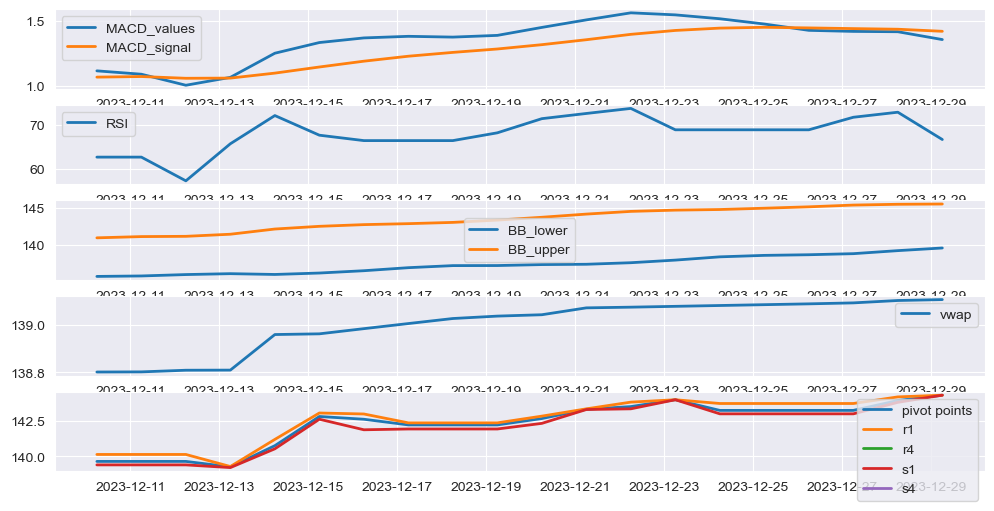

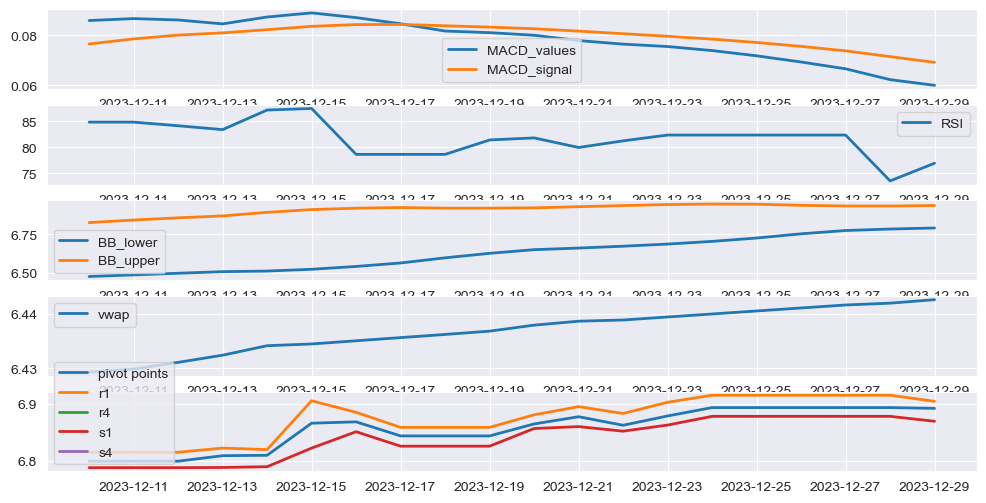

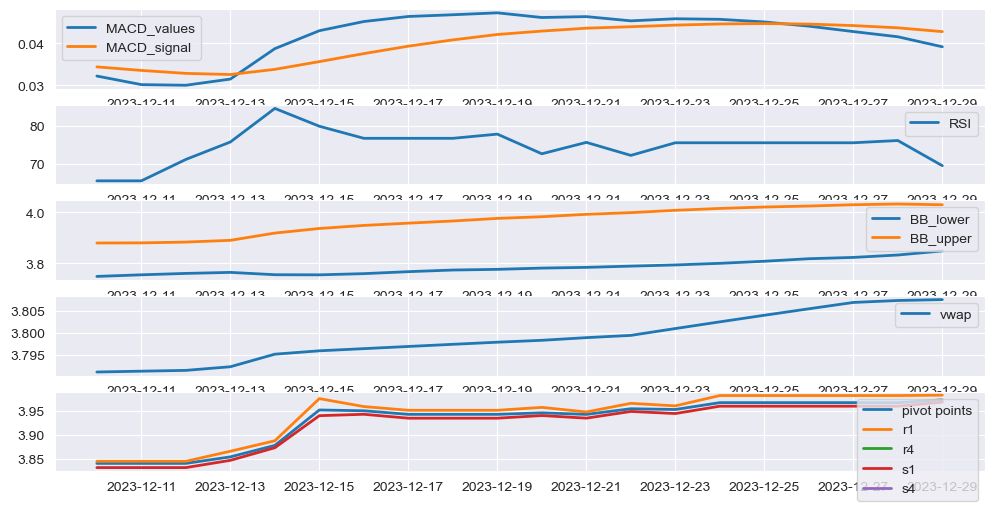

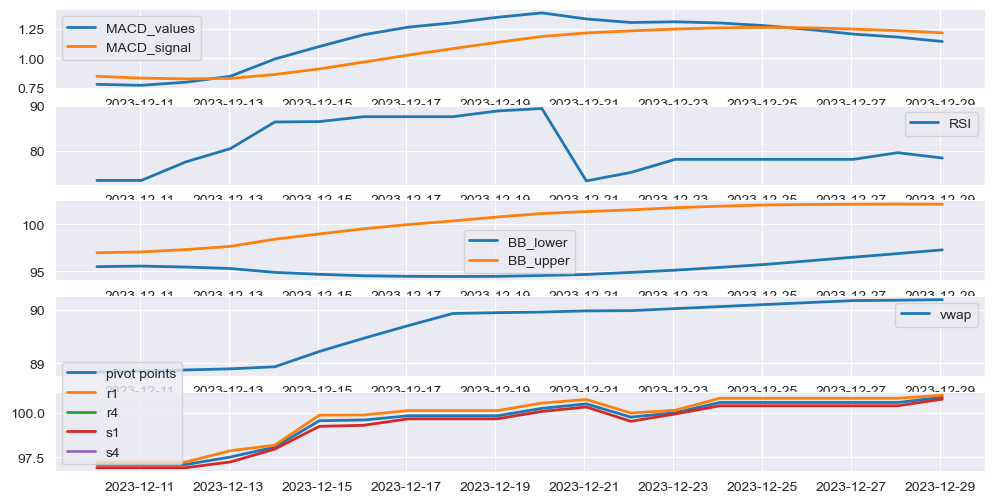

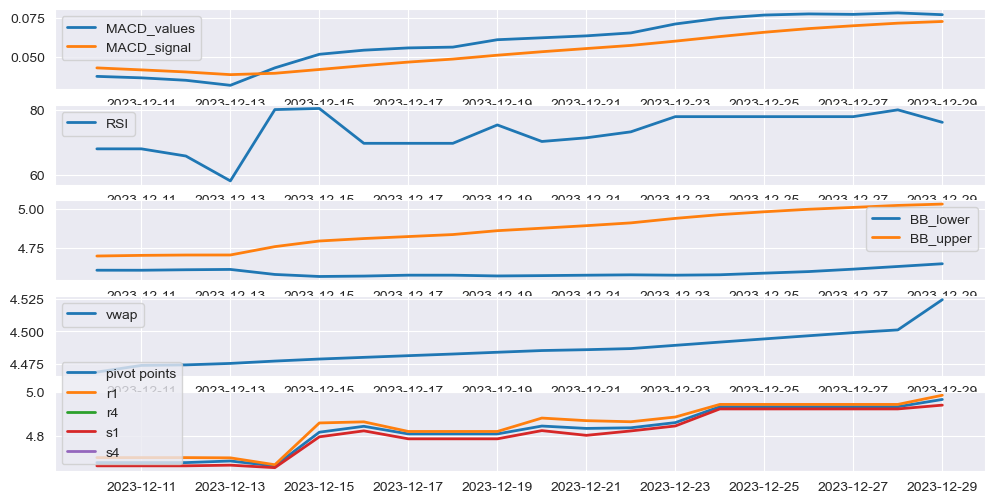

In [62]:
fund_name_fund_df, sum_plt = technical_indicators_factory(dataframes_funds, funds_for_hedge)

In [63]:
GIGAFUND = portfolio_factory(etfs=dataframes_funds)

In [90]:
GIGAFUND_NORM = GIGAFUND.copy()

columns_to_normalize = ["Open", "High", "Low", "Close", "Volume", "Return", "Rolling Volatility"]

GIGAFUND_NORM[columns_to_normalize] = (
    GIGAFUND_NORM[columns_to_normalize]
    .apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
)

In [91]:
GIGAFUND_NORM

,index,Open,High,Low,Close,Volume,Return,Rolling Volatility,Bullish,Bearish,isOverbought,isOversold,time_idx,group_id
0,2023-01-03 00:00:00+00:00,0.949093,0.951707,0.949099,0.951708,0.001870,0.404490,0.326833,0,0,0,0,0,0
1,2023-01-04 00:00:00+00:00,0.951712,0.951707,0.951717,0.951708,0.000000,0.404490,0.326833,0,0,0,0,1,0
2,2023-01-05 00:00:00+00:00,0.951468,0.951463,0.948750,0.950556,0.004450,0.386149,0.326833,0,0,0,0,2,0
3,2023-01-06 00:00:00+00:00,0.965587,0.965584,0.964767,0.964761,0.000387,0.630869,0.326833,0,0,0,0,3,0
4,2023-01-07 00:00:00+00:00,0.966488,0.966485,0.965221,0.965215,0.001032,0.404490,0.326833,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,2023-12-24 00:00:00+00:00,0.009465,0.009366,0.009425,0.009323,0.053730,0.404490,0.328282,1,0,1,0,357,4
1804,2023-12-25 00:00:00+00:00,0.009465,0.009366,0.009425,0.009323,0.053730,0.404490,0.161586,1,0,1,0,358,4
1805,2023-12-26 00:00:00+00:00,0.009465,0.009366,0.009425,0.009323,0.053730,0.606297,0.281416,1,0,1,0,359,4
1806,2023-12-27 00:00:00+00:00,0.009658,0.009711,0.009598,0.009505,0.043859,0.486764,0.286456,1,0,1,0,360,4


In [92]:
duplicate_rows = GIGAFUND_NORM[GIGAFUND_NORM.duplicated(subset=["time_idx", "group_id"], keep=False)]
print(duplicate_rows)

Empty DataFrame
Columns: [index, Open, High, Low, Close, Volume, Return, Rolling Volatility, Bullish, Bearish, isOverbought, isOversold, time_idx, group_id]
Index: []


In [93]:
gftft, gftr, gfv = fit(epochs=10, batch_size=128, lr=1e-3, dropout=0.1, df=GIGAFUND_NORM, independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"], target="Close")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 24/24 [00:04<00:00,  5.10it/s, v_num=27, train_loss_step=0.00581]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 24/24 [00:04<00:00,  5.12it/s, v_num=27, train_loss_step=0.00468, val_loss=0.00801, train_loss_epoch=0.0065]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 24/24 [00:04<00:00,  5.12it/s, v_num=27, train_loss_step=0.00435, val_loss=0.00602, train_loss_epoch=0.00487]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 24/24 [00:04<00:00,  5.13it/s, v_num=27, train_loss_step=0.00335, val_loss=0.00516, train_loss_epoch=0.00431]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 24/24 [00:04<00:00,  5.07it/s, v_num=27, train_loss_step=0.00269, val_loss=0.00487, train_loss_epoch=0.0039] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 24/24 [00:04<00:00,  5.02it/s, v_num=27, train_loss_step=0.00255, val_loss=0.00537, train_loss_epoch=0.00309]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:05<00:00,  4.64it/s, v_num=27, train_loss_step=0.00169, val_loss=0.00319, train_loss_epoch=0.00178]


In [94]:
IE_indicators_preds = predict(gftft, gftr, gfv)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [96]:
normalized = dataframes_funds[1][columns_to_normalize] = (
    dataframes_funds[1][columns_to_normalize]
    .apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
)

362
62


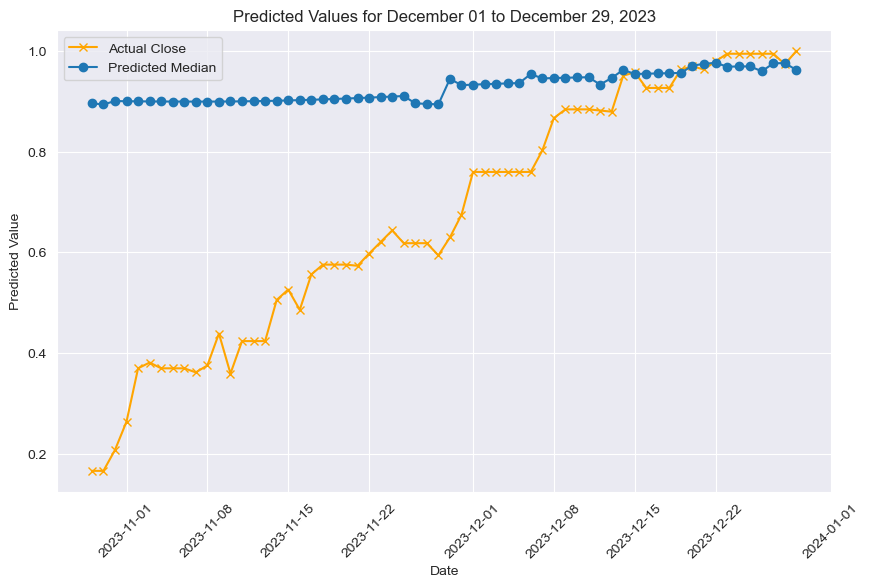

In [97]:
mse, plt, mape, huber = metrics_and_plt(dataframes_funds[1], IE_indicators_preds, pd.date_range(start="2023-10-29", end="2023-12-29"), date="2023-10-29")

In [ ]:
IE_tft_rem, IE_tft_rem_training = fit(epochs=220, batch_size=128, lr=1e-3, dropout=0.1, df=df_scary,
                                      independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"],
                                      target="Remainders")

In [84]:
dataframes_funds[1]

,Open,High,Low,Close,Volume,Return,Rolling Volatility,Bullish,Bearish,isOverbought,isOversold
2023-01-02 00:00:00+01:00,5.995000,6.035000,5.960000,6.035000,51252.000000,0.004474,0.007348,0,0,0,0
2023-01-03 00:00:00+01:00,6.037000,6.098000,6.037000,6.062000,22253.000000,0.004474,0.007348,0,0,0,0
2023-01-04 00:00:00+01:00,6.100000,6.175000,6.100000,6.175000,4569.000000,0.018641,0.007348,0,0,0,0
2023-01-05 00:00:00+01:00,6.146000,6.179000,6.141000,6.162000,10513.000000,-0.002105,0.007348,0,0,0,0
2023-01-06 00:00:00+01:00,6.154000,6.228000,6.154000,6.228000,4663.000000,0.010711,0.007348,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 00:00:00+01:00,6.909000,6.909000,6.872000,6.900000,51450.000000,0.000000,0.001855,0,1,1,0
2023-12-26 00:00:00+01:00,6.909000,6.909000,6.872000,6.900000,51450.000000,0.000000,0.000877,0,1,1,0
2023-12-27 00:00:00+01:00,6.909000,6.909000,6.872000,6.900000,51450.000000,0.001888,0.001063,0,1,1,0
2023-12-28 00:00:00+01:00,6.911000,6.915000,6.880000,6.882000,31124.000000,-0.002609,0.001542,0,1,1,0


In [ ]:
IE_tft_rem_preds, IE_tft_rem_training = predict(IE_tft_rem, IE_tft_rem_training, data)

In [ ]:
IE_model2_mse, IE_model2_plt = metrics_and_plt(df_scary, IE_tft_rem_preds,
                                               pd.date_range(start="2023-12-23", end="2023-12-29"), target="Remainders",
                                               date="2023-12-23")

In [ ]:
final_preds = IE_indicators_preds.copy()[-7:] + IE_tft_rem_preds

In [ ]:
final_mse = mean_squared_error(IE_indicators["EWSA.AS"]["Close"][-7:], final_preds)
final_mse

MONTER CARLOS PREDICTING RISK

In [ ]:
def calc_drift(fund):
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    avg_pdr = log_returns.mean()
    var = log_returns.var()
    drift = avg_pdr-(.5*var)

    return drift

In [ ]:
def monte_carlo_sim(fund):
    drift = calc_drift(fund)
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    stdev=log_returns.std()
    days=362
    trials=100
    Z = norm.ppf(np.random.rand(days,trials))
    daily_returns=np.exp(np.array(drift) + np.array(stdev) * Z)
    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = fund["Close"].iloc[-1]
    for i in range(1,days):
        price_paths[i] = price_paths[i-1] * daily_returns[i]
    return price_paths

In [ ]:
drifts=calc_drift(funds_w_names["EWSA.AS"])
pp=monte_carlo_sim(funds_w_names["EWSA.AS"])

In [ ]:
def volatility_mc(price_paths: pd.DataFrame):
    pp_df = pd.DataFrame(price_paths)
    pp_df= pp_df.pct_change()
    pp_df.fillna(value=0, inplace=True)
    pp_df=pp_df.rolling(7).std()
    pp_df.fillna(method="bfill", inplace=True)
    return np.mean(pp_df)

In [ ]:
volatility_mc(pp)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(pp)

TEZ DO KOSZA

In [ ]:
list_of_5_df_funds = []

In [ ]:
def nearest_positive_definite(matrix):
    P = matrix.copy()
    eigvals, eigvecs = np.linalg.eigh(P)
    eigvals[eigvals < 0] = 1e-10
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [ ]:
variances = {}
covs_means = []
for k,v in funds_w_names.items():
    variances[k] = v["Rolling Volatility"]
variances = pd.DataFrame(variances)
r = variances.pct_change()
covariance_matrix = r.cov()
mean_returns = r.mean()

In [ ]:
if not np.all(np.linalg.eigvals(covariance_matrix) > 0):
    print("Covariance matrix not positive definite. Adding regularization.")
    covariance_matrix = nearest_positive_definite(covariance_matrix)

In [ ]:
#to be filled with real data
portfolio_weights = np.random.random(len(mean_returns)) # distribution of etfs in portfolio
portfolio_weights /= np.sum(portfolio_weights)

In [ ]:
initial_portfoloio = 0
for i, v in enumerate(funds_w_names.values()):
    initial_portfoloio += portfolio_weights[i] * v["Close"][i]

In [ ]:
days = 60
simulations = 100
portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns).T # days x all etfs

In [ ]:
initial_portfoloio

In [ ]:
for s in range(0, simulations):
    Z = np.random.normal(size=(days, len(portfolio_weights)))
    L = np.linalg.cholesky(covariance_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_portfoloio

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Simulations")

expected volatility

In [ ]:
portfolio_returns = portfolio_sims[-1] / portfolio_sims[0] - 1  # final value over initial value gives portfolio returns
portfolio_volatility = np.std(portfolio_returns)
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_sims)
plt.title("Monte Carlo Simulations of Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()

expected return

In [ ]:
discounted_prices = [sim[-1]*0.96 for sim in portfolio_sims]

In [ ]:
avg = np.average(discounted_prices)

MONTE CARLO EVALUATION FUNCITON

In [ ]:
def test_robustness(paths, num_trials, tol=0.01):
    means = []
    for i in range(num_trials):
        np.random.seed(i)
        new_paths = np.random.choice(paths, size=len(paths), replace=True)
        means.append(np.mean(new_paths))
    glob_mean = np.mean(means)
    devs = np.abs(np.array(means) - glob_mean)
    return max(0, 1 - (np.mean(devs) / (tol*glob_mean)))

In [ ]:
def compute_convergence_rate(paths, true_val):
    cum_means = np.cumsum(paths)/np.arange(1, len(paths)+1)
    difs = np.abs(cum_means - true_val)
    final = difs[-1]
    avg = np.mean(difs)
    if avg == 0.0:
        return 1.0
    return max(0, 1-(final/avg))

In [ ]:
def rate_mc_simulation(paths, true_value, runtime, weights):
    mean_estimate = np.mean(paths)
    variance = np.var(paths)
    bias = mean_estimate - np.mean(true_value)
    mse = bias**2 + variance
    efficiency = 1 / (runtime * mse)

    robustness = test_robustness(paths.mean(axis=1), 150)

    convergence_rate = compute_convergence_rate(paths.mean(axis=1), true_value)

    score = (
            weights[0] * convergence_rate +
            weights[1] * (1 / np.std(paths)) +
            weights[2] * (1 / abs(bias)) +
            weights[3] * (1 / variance) +
            weights[4] * efficiency +
            weights[5] * robustness)
    return score

In [ ]:
weights=[1/6,1/6,1/6,1/6,1/6,1/6]
pd.Series(pp['EWSA.AS'].mean(axis=1))

In [ ]:
print((rate_mc_simulation(pp['EWSA.AS'], funds_w_names["EWSA.AS"]["Close"], 0.1, weights)))

REDESIGN PORTFOLIO

In [ ]:
'''
list of predictions for each fund in portfolio
'''
portfolio = funds_for_hedge
preds_for_portfolio = []
for i in portfolio:
    preds_for_portfolio.append(predict(29, funds_w_names[i]))

In [ ]:
'''
calculate ratio of a single fund based on provided predictions
'''
def calculate_funds_ratio(funds_preds, fund: pd.DataFrame):
    funds_return = fund["Close"].iloc[-1] - funds_preds["Close"].iloc[-1]
    funds_risk = volatility_mc(monte_carlo_sim(fund))
    return funds_return/funds_risk, funds_return

In [ ]:
from scipy.optimize import minimize
def redistribute_funds(funds_dfs:list, weights: list):
    """
    for a given portfolio, calculate risk and return for next month for each asset and decide whether to buy more of it
    funds_dfs is a list of funds dataframes based on portfolio
    weights is a list of weights for each funds
    """

    def objective(w):
        portfolio_score = 0
        for i in (range(len(funds_dfs))):
            ratio, returnn, preds = calculate_funds_ratio(preds_for_portfolio, funds_dfs[i])
            portfolio_score += ratio * w[i]
            return -portfolio_score

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0,1)] * len(funds_dfs)
    result = minimize(objective, np.ndarray(weights), method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    optimized_score = result.fun

    returns = [calculate_funds_ratio(preds_for_portfolio[i], funds_dfs[i])[1] for i in range(len(portfolio))]
    final_gain = optimized_weights*returns

    return optimized_weights, optimized_score, final_gain

works for small Ns, max 10

In [ ]:
import numpy as np
import pandas as pd

def design_optimal_portfolio(N: int):
    available_funds = list(funds_w_names.keys())
    fund_combinations = list(combinations(available_funds, N))

    best_score = -np.inf
    best_weights = None
    best_selected_funds = None
    best_final_gains = None

    for selected_funds in fund_combinations:

        funds_dfs = [funds_w_names[fund] for fund in selected_funds]


        preds_for_selected_funds = []
        for fund in selected_funds:
            preds_for_selected_funds.append(predict(29, funds_w_names[fund]))


        def objective(w):
            portfolio_score = 0
            for i in range(len(funds_dfs)):
                ratio, returnn, _ = calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])
                portfolio_score += ratio * w[i]
            return -portfolio_score


        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1)] * N

        initial_weights = np.ones(N) / N

        result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

        optimized_weights = result.x
        optimized_score = -result.fun

        returns = [calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])[1] for i in range(N)]
        final_gains = np.dot(optimized_weights, returns)

        if optimized_score > best_score:
            best_score = optimized_score
            best_weights = optimized_weights
            best_selected_funds = selected_funds
            best_final_gains = final_gains

    return best_weights, best_score, best_final_gains, best_selected_funds

In [ ]:
N = 5
best_weights, best_score, best_final_gains, best_selected_funds = design_optimal_portfolio(N)

print("Selected funds:", best_selected_funds)
print("Optimized weights:", best_weights)
print("Best gain:", best_final_gains)

works for large Ns

In [ ]:
import random
from scipy.optimize import minimize
from itertools import combinations

def calculate_fitness(preds_for_selected_funds, funds_dfs, weights):
    portfolio_score = 0
    for i in range(len(funds_dfs)):
        ratio, returnn, _ = calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])
        portfolio_score += ratio * weights[i]
    return portfolio_score

def genetic_algorithm(funds_w_names, N, population_size=50, generations=100, mutation_rate=0.1, crossover_rate=0.8):
    available_funds = list(funds_w_names.keys())
    fund_combinations = list(combinations(available_funds, N))

    population = []
    for _ in range(population_size):
        selected_funds = random.sample(fund_combinations, 1)[0]
        weights = np.random.rand(N)
        weights /= np.sum(weights)
        population.append((selected_funds, weights))

    best_solution = None
    best_fitness = -np.inf

    for generation in range(generations):
        fitness_scores = []
        preds_for_selected_funds_list = []
        funds_dfs_list = []

        for selected_funds, _ in population:
            funds_dfs = [funds_w_names[fund] for fund in selected_funds]
            preds_for_selected_funds = []
            for fund in selected_funds:
                preds_for_selected_funds.append(predict(29, funds_w_names[fund]))
            preds_for_selected_funds_list.append(preds_for_selected_funds)
            funds_dfs_list.append(funds_dfs)

        for i in range(population_size):
            selected_funds, weights = population[i]
            fitness = calculate_fitness(preds_for_selected_funds_list[i], funds_dfs_list[i], weights)
            fitness_scores.append(fitness)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = (selected_funds, weights)

        selected_parents = []
        fitness_sum = np.sum(fitness_scores)
        prob = [score / fitness_sum for score in fitness_scores]

        for _ in range(population_size):
            selected_parent = random.choices(population, prob)[0]
            selected_parents.append(selected_parent)

        new_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected_parents[i], selected_parents[i+1]
            if random.random() < crossover_rate:
                crossover_point = random.randint(1, N-1)  # Crossover at a random point
                offspring1 = (parent1[0][:crossover_point] + parent2[0][crossover_point:],
                              np.concatenate((parent1[1][:crossover_point], parent2[1][crossover_point:])))
                offspring2 = (parent2[0][:crossover_point] + parent1[0][crossover_point:],
                              np.concatenate((parent2[1][:crossover_point], parent1[1][crossover_point:])))
                new_population.extend([offspring1, offspring2])
            else:
                new_population.extend([parent1, parent2])

        for i in range(population_size):
            if random.random() < mutation_rate:
                selected_funds, weights = new_population[i]
                mutation_idx = random.randint(0, N-1)
                weights[mutation_idx] = random.random()
                weights /= np.sum(weights)  # Normalize weights to sum to 1
                new_population[i] = (selected_funds, weights)

        population = new_population

    return best_solution, best_fitness

In [ ]:
N = 5
best_solution, best_fitness = genetic_algorithm(funds_w_names, N)

selected_funds, optimized_weights = best_solution
print("Selected funds:", selected_funds)
print("Optimized weights:", optimized_weights)
print("Best fitness (risk-adjusted return):", best_fitness)